<img src="imgs/IISc_Master_Seal_Black_Transparent.png" height="120px" width="120px" align="right" />

<img src="imgs/logoGESS.jpg" height="120px" width="120px" align="right" />

<font face="Calibri">
<font size="7"> <b> PySHBundle Tutorials </b> </font>
<br> 
<font size="5"> <b> Tutorial 4: Terrestrial Water Storage Time Series<font color='rgba(200,0,0,0.2)'>  </font> </b> </font>
<br> <br>
    
<font size="3"> <b> by: Abhishek Mhamane<sup>1</sup>, Vivek Kumar Yadav<sup>2</sup> <br>
<sup>1</sup>IIT Kanpur, <sup>2</sup>ICWaR, IISc Bengaluru</b> 
<font size="2">  <br>
<font> <b>Date: </b> June 07, 2024 </font>
</font>

## Processing GRACE level 2 spherical harmonics data into terrestrial water storage anomalies (TWSA)

This notebook explains each step of getting TWSA field, followed by the process itself.

It is divided into three sections,
* A. Acquiring corrected GRACE level 2 spherical harmonics data.
* B. Processing (A) into global TWSA anomaly field.
* C. (Additional) Clipping TWSA for a particular basin and calculating basin average TWSA time series.

### **A**. Acquiring corrected GRACE level 2 spherical harmonics data

### A.1 Importing the necessary libraries

In [1]:
import os
import sys
from datetime import datetime
from collections import OrderedDict
import numpy as np
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
# Add the folder path to the Python path
folder_path = '../pyshbundle/'
sys.path.append(folder_path)

In [2]:
from pyshbundle.hydro import TWSCalc
from pyshbundle.io import extract_SH_data, extract_deg1_coeff_tn13, extract_deg2_3_coeff_tn14
from pyshbundle.viz_utils import plot_calendar_months

Initializing PySHbundle v0.2.1


### A.2 Specifying the path to input data.
As part of the package we provide the input data from 3 centres `JPL`, `CSR` & `ITSG` and the corresponding (recommended) Technical notes (`TN13`, `TN14`) files as well. User may download there own solutions and provide their paths below.

In [3]:
source='jpl'
path_sh = "../sample_input_data/JPL_input/"
# source='csr'
# path_sh = "../sample_input_data/CSR_input/"
# source='itsg'
# path_sh = "../sample_input_data/ITSG_input/"

path_tn14 = "../pyshbundle/data/JPL_TN_files/TN-14_C30_C20_GSFC_SLR.txt"    # Path to TN14
path_tn13 = "../pyshbundle/data/JPL_TN_files/TN-13_GEOC_JPL_RL06.txt"       # Path to TN13

In [4]:
files = os.listdir(path_sh)
if str.upper(source) == 'ITSG':
    file_paths = [path_sh + file for file in files if os.path.splitext(file)[1] == '.gfc'];
else:
    file_paths = [path_sh + file for file in files if os.path.splitext(file)[1] == '.gz'];

### A3. Process each file and store the data in the main dictionary
Dictionary to store the extracted data, the data can be accessed using the standard format of any python dictionary with the *key-value* pair. Access using `extracted_data['yyyy-mm'][(degree, order)]`


In [5]:
extracted_data={} 
for file_path in file_paths:
    # file_data = read_sh(file_path, source=source)
    file_data = extract_SH_data(file_path, source=source)
    if file_data['time_coverage_start']:
        # Convert time_coverage_start to a datetime object and then format it as yyyy-mm
        if source == 'itsg':
            start_date = datetime.strptime(file_data['time_coverage_start'][-7:], '%Y-%m').strftime('%Y-%m')
        else:
            start_date = datetime.strptime(file_data['time_coverage_start'], '%Y-%m-%dT%H:%M:%S.%f').strftime('%Y-%m')
        # Use the formatted date as the key
        extracted_data[start_date] = file_data['coefficients']


# Time Sort the dictionary by keys (dates)
sorted_data = OrderedDict(sorted(extracted_data.items()));

* Lets quickly visualize which month and years of data you have.

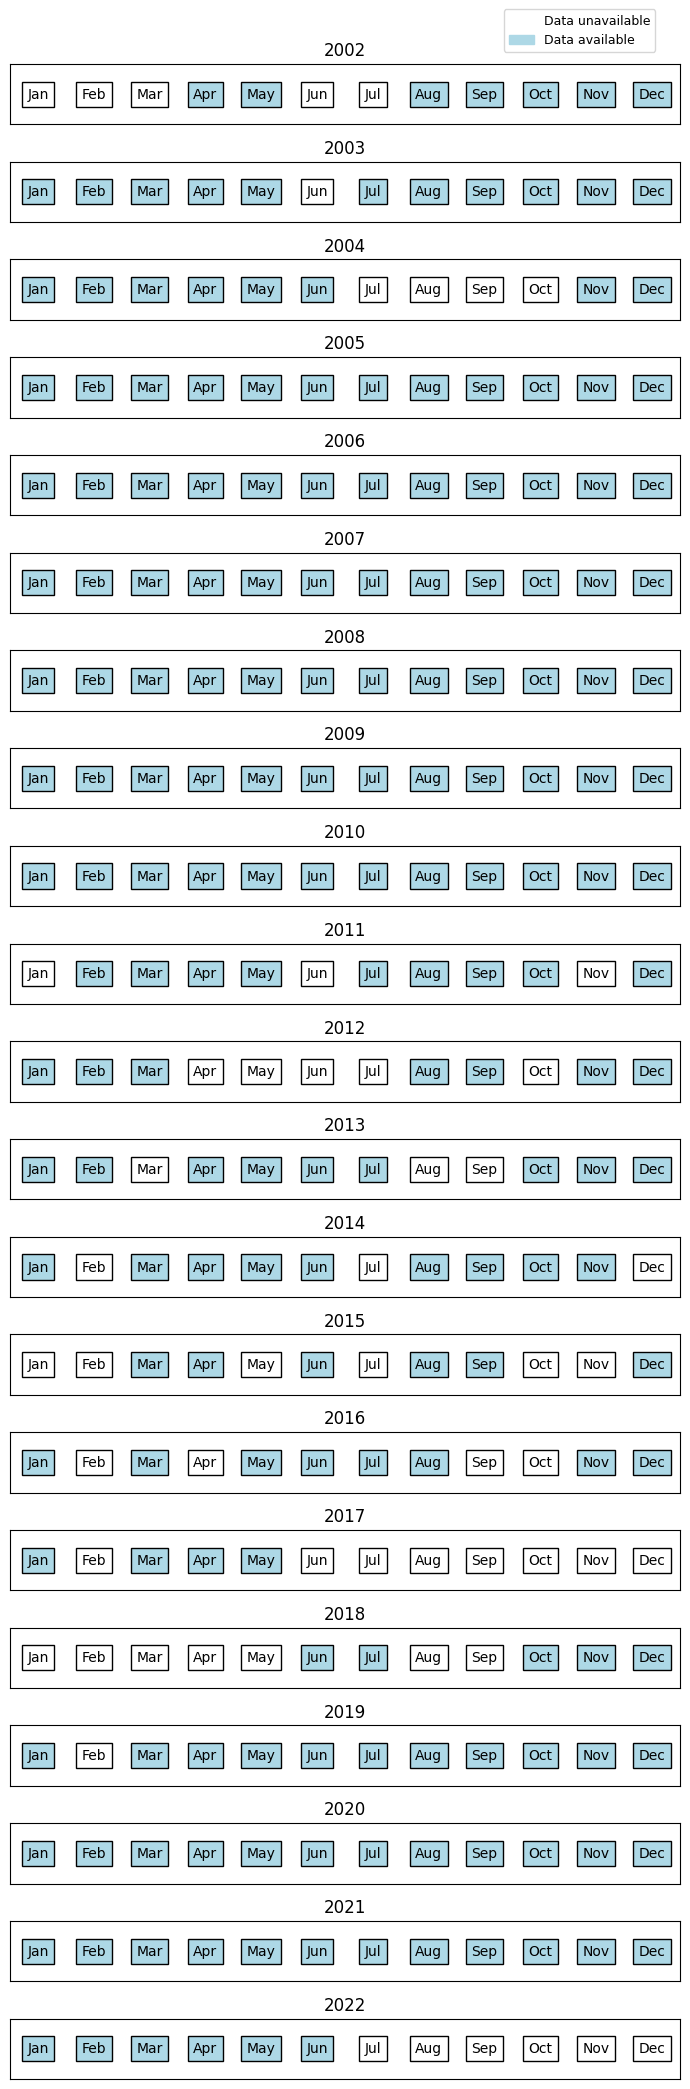

In [6]:
datetime_object = sorted_data.keys()

plot_calendar_months(datetime_object)

### A4. Nested *dictionary* structure of the extracted and time sorted data
The keys of the `sorted_data` dictionary are the dates in the format `(yyyy-mm)`. 

Each key as a dictionary for a particular `(yyyy-mm)` pair has list of dictionaries for each `(degree, order)` pair that was read from the data, see example below.

In [7]:
print(list(sorted_data.keys())[0:5], '\n')             # dicitonary for each year-month, printing only first 5
print(list(sorted_data['2002-04'].keys())[0:5], '\n')  # dictionary for each degree and order, , printing only first 5
print(sorted_data['2002-04'][(2,0)].keys(), '\n')      # dictionary with the data for repective year-month, degree and order
print('Clm value for (degree, order)=(2,0) is:', sorted_data['2002-04'][(2,0)]['Clm'])

['2002-04', '2002-05', '2002-08', '2002-09', '2002-10'] 

[(2, 0), (2, 1), (2, 2), (3, 0), (3, 1)] 

dict_keys(['Clm', 'Slm', 'Clm_sdev', 'Slm_sdev']) 

Clm value for (degree, order)=(2,0) is: -0.000484169317396


### A5. Replacement of degree 2,3 coefficients
Since the degree 2 & 3 (order 0) coefficients from GRACE are errorneous, these need to be replaced with the corresponding data from other sources. 

The recommended method is using Satellite laser ranging data. As mentioned above, we do provide the `TN14` data (JPL, CSR, & ITSG) with the package. Since this data is continuously updated users may download there own solutions for the same and use for replacement of `C20` and `C30` coefficients.

#### A.5.1 Reading data from TN14 file

In [8]:
temp_tn14 = extract_deg2_3_coeff_tn14(path_tn14)

* Once again we use python dictionary to store the replacement `C20`, `C30` coefficients for each `yyyy-mm`. They can be easily accessed as below.

* Note that lot of the starting `C30` values are `None`, since these did not need replacement in the initial years and hence are defined in `TN14` as `None` itself.

In [9]:
print('Keys of the TN14 replacement dictionary', list(temp_tn14.keys())[0:5],)        # dicitonary for each year-month, , printing only first 5
print('Keys of dictionary for year-month 2002-4', temp_tn14['2002-04'].keys())  # dictionary for c20, c30 coefficients for each year-month
print('For 2002-04 :',  '\n'
      'C20 is:', temp_tn14['2002-04']['c20'], '\n'
      'C30 is:',temp_tn14['2002-04']['c30'])

Keys of the TN14 replacement dictionary ['2002-04', '2002-05', '2002-08', '2002-09', '2002-10']
Keys of dictionary for year-month 2002-4 dict_keys(['year_frac_start', 'mjd_start', 'c20', 'c20_mean_diff', 'c20_sigma', 'c30', 'c30_mean_diff', 'c30_sigma', 'mjd_end', 'year_frac_end'])
For 2002-04 : 
C20 is: -0.00048416932630052 
C30 is: None


#### A.5.2 Replacing C20 values in `sorted_data` with the values from `temp_tn14` dictionary 

In [10]:
for date_key in temp_tn14.keys():
    if date_key in sorted_data.keys():
        sorted_data[date_key][(2,0)]['Clm'] = temp_tn14[date_key]['c20']
        if temp_tn14[date_key]['c30'] is not None:
            sorted_data[date_key][(3,0)]['Clm'] = temp_tn14[date_key]['c30'];

### A.6 Replacement of degree 1 coefficients

Since GRACE does not provide degree 1 coeffieicents, we need to replace (insert) them to get the complete spherical harmonics data starting from (degree, order) [0,0] to [$l_{max}$, $m_{max}$]

The degree 1 coefficients are provided by various centres and are called Techinical notes 13. Similar to TN14, Pyshbundle includes TN13 files from JPL, CSR & ITSG. Users are suggested to download there own solutions for use since the TN13 & TN14 data in pyshbundle will not be updated frequently.

#### A.6.1 Reading data from TN13 file

In [11]:
temp_tn13=extract_deg1_coeff_tn13(path_tn13)

* The data from TN13 is again saved with a *key-value* pair for each `year-month`. As mentioned above, the coefficients we get from TN13 are `C10`, `S10`, `C11`, `S11`. It can be accessed as below.

In [12]:
print('Keys of the TN13 replacement dictionary', list(temp_tn13.keys())[0:5],)        # dicitonary for each year-month, printing only first 5
print('Keys of dictionary for year-month 2002-4', temp_tn13[('2002-04', 1, 0)].keys())  # dictionary for c20, c30 coefficients for each year-month
print('For 2002-04 :',  '\n'
       'C10 is:', temp_tn13[('2002-04', 1, 0)]['Clm'], '\n'
       'S10 is:', temp_tn13[('2002-04', 1, 0)]['Slm'], '\n'
       'C11 is:', temp_tn13[('2002-04', 1, 1)]['Clm'], '\n'
       'C11 is:', temp_tn13[('2002-04', 1, 1)]['Slm'])

Keys of the TN13 replacement dictionary [('2002-04', 1, 0), ('2002-04', 1, 1), ('2002-05', 1, 0), ('2002-05', 1, 1), ('2002-08', 1, 0)]
Keys of dictionary for year-month 2002-4 dict_keys(['degree', 'order', 'Clm', 'Slm', 'Clm_sdev', 'Slm_sdev', 'epoch_begin', 'epoch_end'])
For 2002-04 : 
C10 is: 4.935091508e-10 
S10 is: 0.0 
C11 is: 2.407968956e-10 
C11 is: -6.808848629e-11


* Since **JPL** solutions do not provide degree 1 coeffs (`C10`, `C11`, `S10`, `S11`) new dictionary key-value pairs need to be initialized for them with 0 values. We shall replace them in the next step

In [13]:
if str.upper(source)=='JPL':
    for key in sorted_data:
        sorted_data[key][(0, 0)] = {'Clm': 0.0, 'Slm': 0.0, 'Clm_sdev': 0.0, 'Slm_sdev': 0.0}
        sorted_data[key][(1, 0)] = {'Clm': 0.0, 'Slm': 0.0, 'Clm_sdev': 0.0, 'Slm_sdev': 0.0}
        sorted_data[key][(1, 1)] = {'Clm': 0.0, 'Slm': 0.0, 'Clm_sdev': 0.0, 'Slm_sdev': 0.0};
else: pass

#### A.6.2 Replacing degree 1 values in `sorted_data` with the values from `temp_tn13` dictionary

In [14]:
for date_key in temp_tn13.keys():
    if date_key[0] in sorted_data.keys():
        # print(date_key)
        sorted_data[date_key[0]][(date_key[1], date_key[2])]['Clm'] = temp_tn13[date_key]['Clm']
        sorted_data[date_key[0]][(date_key[1], date_key[2])]['Slm'] = temp_tn13[date_key]['Slm']
        sorted_data[date_key[0]][(date_key[1], date_key[2])]['Clm_sdev'] = temp_tn13[date_key]['Clm_sdev']
        sorted_data[date_key[0]][(date_key[1], date_key[2])]['Slm_sdev'] = temp_tn13[date_key]['Slm_sdev'];

Lets see how many months of data we have and what is the maximum degree ($l_{max}$) and order ($m_{max}$) present in our data.

In [15]:
max_degree=np.max([degree for date in sorted_data.keys() for degree, order in sorted_data[date].keys()])
max_order=np.max([order for date in sorted_data.keys() for degree, order in sorted_data[date].keys()])
number_of_months=len(sorted_data.keys())
print('The maximum degree & order in data is:' , max_degree, '&', max_order)
print('Number of months for which data is available:', number_of_months)

The maximum degree & order in data is: 96 & 96
Number of months for which data is available: 196


#### A.7 Processing level 2 spherical harmonics data

Depending on the use, GRACE spherical harmonics data is stored in various formats such as `/S|C\`, `C|S` and `KLM`. The two figures below show the most common formats.
/Users/vivek/jupyter_nbs/gitrepos/pyshbundle/notebooks/imgs/sc_matrix.png
<center>
<img alt="CS matrix" src="./imgs/cs_matrix.png" width="500" height="300">
<center>
<img alt="SC matrix" src="./imgs/sc_mat.png" width="700" height="350">

### A.7.1 Lets save the data in `/S|C\` format

* Now that we are done with accquring the data and replaced erroneous and missing coefficients. Lets store the SH coeffiecients in `clm` format.

* Since the `sorted_data` has the (degree, order) pair as a key for each month, we can access the coefficients using those itself. Below is a simple `for` loop which implements it.

In [16]:
sc_mat=np.zeros([number_of_months, max_degree+1, 2*(max_degree+1)], dtype=np.longdouble)

for index, key in enumerate(sorted_data.keys()):
    temp=sorted_data[key]
    for l in range(0,max_degree+1):
        for m in range(0,l+1):
            '''uncomment these two lines to see how the elements are being accessed from the dictionary'''
            # print(l,m)
            # print(temp[(l,m)]['Clm'])
            sc_mat[index, l, max_degree+m+1]=temp[(l,m)]['Clm']
            sc_mat[index, l, max_degree-m]=temp[(l,m)]['Slm']
    del temp

* Since all order 0 coefficients of $S_{lm}$ are 0, we can delete that column.

In [17]:
sc_mat=np.delete(sc_mat, max_degree, axis=2)

### **B**. Processing (A) into global TWSA anomaly fields.

Now that we have obtained the corrected the GRACE spherical harmonics coefficients and stored them in a suitable format (`/S|C\`) we shall now begin the actual processing. The steps that follow will decide the interpretation (with respect to a mean) and spatial resolution of the final solutions.

#### B.1 Removing a temporal mean to get `delta_SC` matrix

* Since the exact density data of the Earth is unkown, a mean gravitational state of the Earth has to be removed.

* This can be done by taking a mean of the spherical harmonics coefficients over a period. The most common choice is taking a mean over the period of January 2003 to December 2010 since there is no gap in this period. However user may choose a different period for taking the mean or simply take a mean over the entire period by commenting out the line below.

In [18]:
SH_long_mean_jpl = np.load('../pyshbundle/data/long_mean/SH_long_mean_jpl.npy')    # load the long term mean SH coeffs---> JPL 
SH_long_mean_csr = np.load('../pyshbundle/data/long_mean/SH_long_mean_csr.npy')    # load the long term mean SH coeffs---> CSR
SH_long_mean_itsg = np.load('../pyshbundle/data/long_mean/SH_long_mean_itsg.npy')    # load the long term mean SH coeffs---> ITSG
delta_sc=np.ones_like(sc_mat)*np.nan
if source== 'jpl':
    delta_sc = sc_mat -   SH_long_mean_jpl
    # delta_sc = sc_mat -   sc_mat.mean(axis=0)      # Remove the mean of the data
elif source== 'csr':
    delta_sc = sc_mat - SH_long_mean_csr
elif source== 'itsg':
    delta_sc = sc_mat - SH_long_mean_itsg

#### B2. $L_{max}$, Gaussian half radius and grid resolution

* $L_{max}$
   
  Now we choose the truncation limit of the spherical harmonics expansion.
  
  Know that the upper limit of this expansion is the maximum degree coefficient present in your data. 
  Thus the highest limit can be $l_{max}$. The higher the limit of truncation, the higher the spatial resolution of the solutions, the trade-off being increasing levels of noise.

* Gaussian half radius

  Since the GRACE spherical harmonics coefficients are extremely nosiy, certain levels of filtering are required to reduce the same.

  The simplest form of filtering is applying a Gaussian filter. More advance methods of filtering do exist such as `etc` as well as dynamic filters such as DDK, DDK5.

  We provide Gaussian filtering, the filter can be imagined as a symmetrical hat moving (convolution) over the surface of the sphere (Earth in our case), weighting the values under it. The extent of surrounding weighting is decided by the radius of the filter. The values can be calculated using the `Gaussian()` function. The function takes in the maximum degree to which the filterhas to be created for, and the radius of the Gaussian function. Since a Gaussian function is a symmterical function, the function only returns only one half of the values. This can be seen below in the plot.

In [19]:
from pyshbundle.shutils import Gaussian
import matplotlib.pyplot as plt

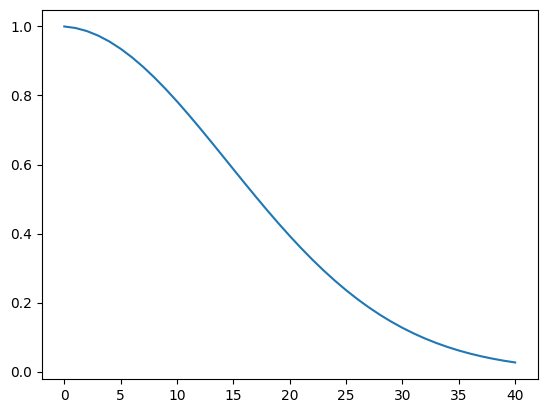

In [20]:
temp=Gaussian(L=40, cap=500);
plt.plot(temp)

* Grid resolution
  
  The resolution of the gridded TWSA fields to which the global spherical harmonics synthesis (`GSHS`) applies is needed to be decided by the user. Depending on their use, they may choose any positive integer for the grid size.

  Users should take note that choosing a finer grid size does not mean a higher spatial resolution of the data since that is mathematically contrained by the limit of truncation ($L_{max}$) of the spherical harmoics function (as mentioned above)

In [21]:
# print('Kindly enter the following parameters based on your application')
# lmax = int(input("Enter lmax: "))
# gs = int(input("Enter grid size: "))
# half_rad_gf = int(input("Enter half radius of Gaussian filter: "))
# print("lmax , grid size & half raduius of gaussian filter are : ", lmax ,", " , gs,", ",half_rad_gf)
lmax,gs,half_rad_gf=96, 1, 500

#### B3. Global spherical harmonics synthesis to get gridded global TWSA data.

Now that we have decided the choices of processing, we shall now do the actual processing.

The `TWSCalc` function does thre things:
* Calls the `Gaussian` function to generate the filtering values.
* Applies the gaussian filter on the `delta_SC` matrix.
* Converts the filtered `delta_SC` matrix to gridded global TWSA field using the `GSHS` function.

100%|██████████| 196/196 [00:05<00:00, 35.00it/s]


CPU times: user 5.49 s, sys: 88 ms, total: 5.57 s
Wall time: 5.62 s


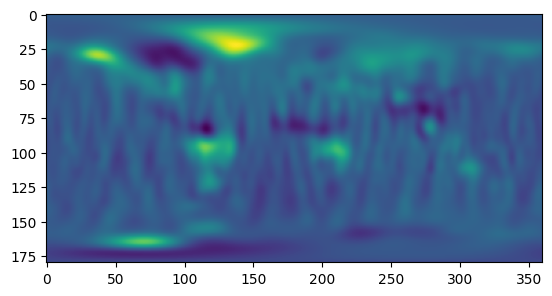

In [22]:
%%time
tws_fields = TWSCalc(delta_sc,lmax, gs,half_rad_gf, number_of_months)

The precision required for the calculations uptill now was of very high order, since the coefficients are of order `1e-12`, with all digits significant. But now we can reduce the precision since the generated TWSA values are of much higher order and lesser singificant digits after (3) decimal. This reduces the size of the dataset and saves system memory.

In [23]:
tws_fields = np.float32(tws_fields)

#### B4. Creating a netcdf dataset

Netcdf is a popular format for sharing climate & hydrological data, let us create a netcdf dataset of our gridded results for easier analysis and sharing.

A global gridded netcdf file needs three coordinates, latitude, longitude and time for the data. We can create the latitude and longitude coordinates using the grid size (`gs`) decided above. The time information can be extracted from the keys of the `sorted_data` dictioanry. 

In [24]:
lon = np.arange(-180,180,gs)
lat = np.arange(89,-91,-gs)
dates = pd.to_datetime(list(sorted_data.keys()), format='%Y-%m',) \
            + pd.offsets.MonthEnd(0)  #.dt.strftime('%d-%m-%Y')

ds = xr.Dataset(
    data_vars=dict(
        tws=(["time","lat", "lon"], tws_fields, {"units": "mm"})
    ),
    coords = {
        # "time":(('time'),dates),
        "time":dates,
        "lat":lat,
        "lon":lon },
    attrs=dict(description="Global gridded TWS Anomaly corresponding to long term (2004-2010) mean", 
               units="mm"),
)
ds

<xarray.Dataset> Size: 51MB
Dimensions:  (time: 196, lat: 180, lon: 360)
Coordinates:
  * time     (time) datetime64[ns] 2kB 2002-04-30 2002-05-31 ... 2022-06-30
  * lat      (lat) int64 1kB 89 88 87 86 85 84 83 ... -85 -86 -87 -88 -89 -90
  * lon      (lon) int64 3kB -180 -179 -178 -177 -176 ... 175 176 177 178 179
Data variables:
    tws      (time, lat, lon) float32 51MB -2.598 -2.549 -2.499 ... 124.4 124.6
Attributes:
    description:  Global gridded TWS Anomaly corresponding to long term (2004...
    units:        mm

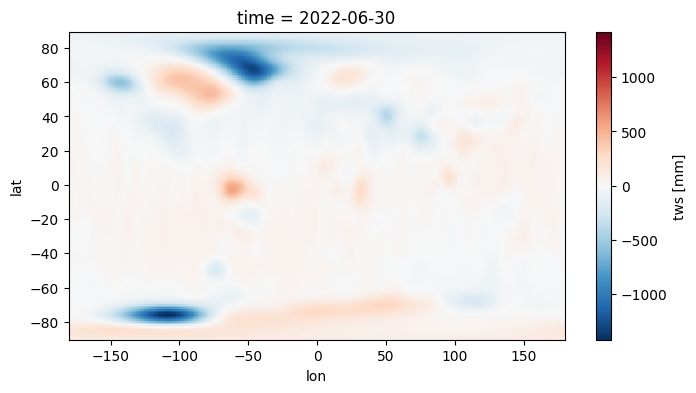

In [25]:
ds['tws'].isel(time=-1).plot(figsize=(8, 4))

## **C**. Clipping TWSA for a particular basin and calculating basin average TWSA time series.
#### (Additional)

For basin-scale analysis such as closing the water budget.

$$
\frac{dS_t}{dt} = P + R +ET
$$

One needs to calculate the change in storage over the entire basin. This can be done by clipping the above global dataset within the region of interest (typically a basin or area shapefile).

Below we use commonly used python packages shapely, gepopandas and rioxarray to clip data from a shapefile for the Ganges basin.

#### C1. Selection of basin or shapefile in region of interest

In [26]:
import geopandas as gpd
import matplotlib.pyplot as plt

* The pyshbundle includes the shapefiles from of the major river basins across the world, obtained from the **HydroBASINS** project `mrb` (major river basins).

* Note that user may find their basin of analysis from the `mrb` as shown below or load their own shapefile and save it in the `shp_basin` variable and its area in the `basin_area` variable

<Axes: >

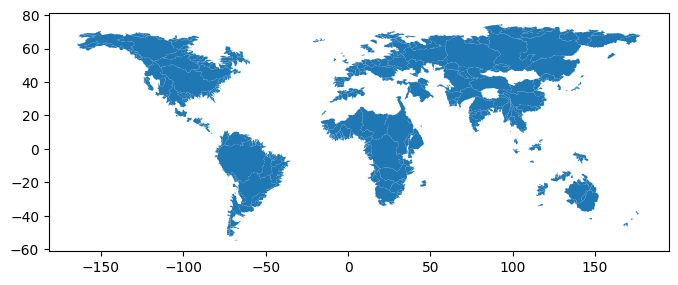

In [27]:
path_shapefile = '/Users/vivek/Desktop/vivek_desktop/mrb_shp_zip/mrb_basins.shp'
shp = gpd.read_file(path_shapefile)
shp.plot(figsize=(8, 4))  

In [28]:
shp

,MRBID,RIVER_BASI,CONTINENT,SEA,OCEAN,SUM_SUB_AR,Shape_Leng,Shape_Area,geometry
0,1201,ATOUI,Africa,North Atlantic,Atlantic Ocean,27695.4,11.874010,2.409224,"POLYGON ((-13.71723 22.88554, -13.71667 22.879..."
1,1202,BANDAMA,Africa,Gulf of Guinea,Atlantic Ocean,99254.1,18.506812,8.107313,"POLYGON ((-5.37917 6.2125, -5.38034 6.21708, -..."
2,1203,BIA,Africa,Gulf of Guinea,Atlantic Ocean,10957.1,7.141522,0.891547,"POLYGON ((-2.69497 7.34616, -2.68797 7.34105, ..."
3,1204,CAVALLY,Africa,Gulf of Guinea,Atlantic Ocean,29622.9,13.092576,2.408952,"POLYGON ((-8.26748 7.93681, -8.26605 7.92701, ..."
4,1205,CESTOS (also NUON),Africa,North Atlantic,Atlantic Ocean,12785.0,8.018670,1.040702,"POLYGON ((-8.38159 7.58785, -8.36667 7.5875, -..."
...,...,...,...,...,...,...,...,...,...
515,6258,VARDAR,Europe,Mediterranean Sea,Atlantic Ocean,24524.3,11.628996,2.652489,"POLYGON ((22.28785 42.44341, 22.29131 42.43992..."
516,6259,VISTULA,Europe,Baltic Sea,Atlantic Ocean,192637.8,46.134741,25.165704,"POLYGON ((24.11667 52.9875, 24.11209 52.98633,..."
517,6260,WESER,Europe,North Sea,Atlantic Ocean,44775.6,19.704562,5.877408,"POLYGON ((8.99244 53.40077, 9.0063 53.39936, 9..."
518,6902,KURA,Europe,Caspian Sea,---,189819.2,34.659441,20.127226,"POLYGON ((44.23576 42.60798, 44.23924 42.60452..."


* Find your basin from the `shp` geodataframe. 
  
  My choice of basin is Ganga basin in the Asian subcontinent.

  I subset the large `shp` geodataframe for the 'Asia' continet and inspect the `temp` variable for the Ganga basin, note that sometimes there maybe difference in the spelling of a certain basin's name. Which is the case with the Ganga basin being spelled as "GANGES".

In [29]:
temp=shp['RIVER_BASI'].where(shp['CONTINENT']=='Asia').dropna()
print(temp)
del temp

86                       ALAZEYA
87                        ANABAR
88                     INDIGIRKA
89                      KHATANGA
90                        KOLYMA
                 ...            
179                   ULUNGUR HU
180             URAL (also ORAL)
181     UVS NUUR (also UBSU-NUR)
182    YSYK-KOL (also ISSYK-KUL)
183             ZHEM (also EMBA)
Name: RIVER_BASI, Length: 96, dtype: object


In [30]:
basin_name='GANGES'

* Now we will extract the shapefile of the basin selected above

     MRBID RIVER_BASI CONTINENT            SEA         OCEAN  SUM_SUB_AR  \
109   2306     GANGES      Asia  Bay of Bengal  Indian Ocean   1006558.6   

     Shape_Leng  Shape_Area                                           geometry  
109  122.349983    90.94688  MULTIPOLYGON (((88.02555 21.5715, 88.02361 21....   

Basin area is : 1006558600000.0 m²


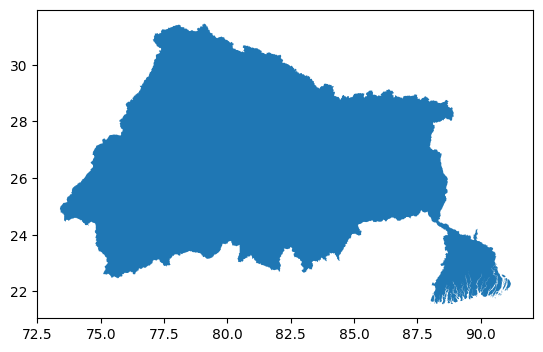

In [31]:
shp_basin=shp[shp['RIVER_BASI']==basin_name]
print(shp_basin.head(), '\n')
shp_basin.plot()
basin_area=np.float64(shp_basin['SUM_SUB_AR'].values[0])*1e6          # basin area already in m^2
print('Basin area is :', basin_area, 'm\u00b2');

#### C2. Area weighting

* Before clipping the data inside the shapefile, the dataset has to be area weighted according to the area of the grid cell. This is due to Earth's spherical shape and size of grids reduces as one moves from the equator towards the poles. This becomes pertinent if the region of interest is spread across several latitudes.

* Thus we area weight our dataset by multiplying the area of each grid with the corresponding grid value. Then we take an average over that area by summing up the values inside the shapefile and dividing by the area of the shapefile (`basin_area`).

* `area_weighting` function generates a matrix with area of each grid at each latitude and longitude box. Once again we use the `gs` variable to create the global area matrix. The plot below shows how the area decreases from the equator to the poles.

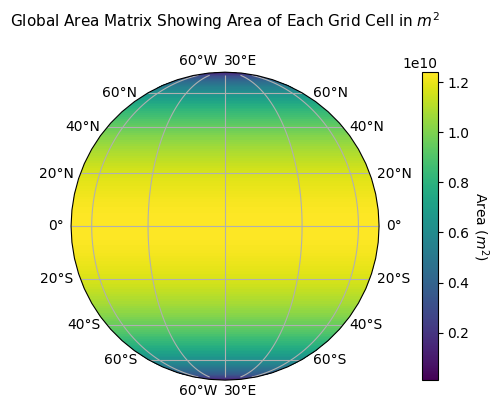

<Figure size 640x480 with 0 Axes>

In [32]:
from pyshbundle.hydro import area_weighting
temp = area_weighting(gs)
lons, lats = np.meshgrid(np.linspace(-180, 180, temp.shape[1]), np.linspace(-90, 90, temp.shape[0]))

fig, ax = plt.subplots(figsize=(8, 4), subplot_kw={'projection': ccrs.Orthographic()})
cax = ax.pcolormesh(lons, lats, temp, cmap='viridis', transform=ccrs.PlateCarree())

# Add a colorbar with a label for clarity
cbar = fig.colorbar(cax, ax=ax, orientation='vertical', pad=0.07)
cbar.set_label('Area ($m^2$)', rotation=270, labelpad=15, fontsize=10)

ax.set_ylabel('Latitude', fontsize=10)
ax.set_xlabel('Longitude', fontsize=10)
ax.gridlines(draw_labels=True)
plt.title('Global Area Matrix Showing Area of Each Grid Cell in $m^2$', fontsize=11, pad=20)
plt.show()
plt.tight_layout()

* Clip data using shapefile

In [33]:
from pyshbundle.hydro import Basinaverage
basin_tws, basin_avg_tws = Basinaverage(ds, gs, shp_basin, basin_area)

In [34]:
basin_avg_tws

<xarray.Dataset> Size: 3kB
Dimensions:  (time: 196)
Coordinates:
  * time     (time) datetime64[ns] 2kB 2002-04-30 2002-05-31 ... 2022-06-30
Data variables:
    tws      (time) float64 2kB 3.438 -25.37 118.6 ... -135.0 -169.7 -184.3

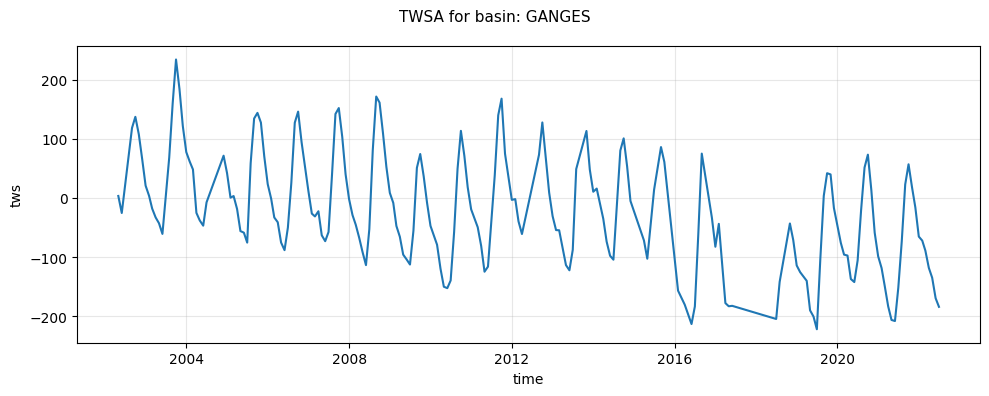

In [35]:
fig = plt.figure(figsize=(10, 4))
basin_avg_tws['tws'].plot()
plt.grid(alpha=0.3)
fig.suptitle(f'TWSA for basin: {basin_name}', fontsize=11)
fig.tight_layout()

#### C4. Adding gaps in the data

The dataset we have created does not yet have the gaps in the time series.

#### C.4.1. First lets create a gapped dataset with NaN values. We will then fill the data that we have and leave the gaps as NaN

* Create a new time index with monthly frequency for the gapped data

In [36]:
new_dates=pd.date_range(start=basin_avg_tws.time[0].values, 
                        end=basin_avg_tws.time[-1].values, freq='ME',)
new_dates

DatetimeIndex(['2002-04-30', '2002-05-31', '2002-06-30', '2002-07-31',
               '2002-08-31', '2002-09-30', '2002-10-31', '2002-11-30',
               '2002-12-31', '2003-01-31',
               ...
               '2021-09-30', '2021-10-31', '2021-11-30', '2021-12-31',
               '2022-01-31', '2022-02-28', '2022-03-31', '2022-04-30',
               '2022-05-31', '2022-06-30'],
              dtype='datetime64[ns]', length=243, freq='ME')

* Initializing an empty dataset for the gapped dataset, `basin_avg_tws_gapped`. 

In [37]:
basin_avg_tws_gapped = xr.Dataset(
        data_vars = dict(   tws=(["time"], np.nan*np.arange(len(new_dates)))),
        coords=dict(time=new_dates),)
basin_avg_tws_gapped

<xarray.Dataset> Size: 4kB
Dimensions:  (time: 243)
Coordinates:
  * time     (time) datetime64[ns] 2kB 2002-04-30 2002-05-31 ... 2022-06-30
Data variables:
    tws      (time) float64 2kB nan nan nan nan nan nan ... nan nan nan nan nan

#### C.4.2. Now fill the data for the months where data is available

* We can use the `.isin()` method to check if the time values in `basin_avg_tws` are present in `basin_avg_tws_gapped`

In [38]:
basin_avg_tws_gapped['time'].isin(basin_avg_tws['time'])  # shows where indices where the dates match

<xarray.DataArray 'time' (time: 243)> Size: 243B
array([ True,  True, False, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False, False, False, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True, False,  True,  True,  True,  True, False,  True,
        True,  True,  True, False, False, False, False,  True,  True,
       False,  True,  True,  True,  True, False,  True,  True,  True,
        True, False, False,  True,  True,  True,  True, False,  True,
        True,  True,  True, False,  True,  True,  True,  True, False,
       False, False,  True,  True, False,  True, False,  True,  True,
       False, False,  True,  True, False,  True, False,  True,  True,
        True,  True, False, False,  True,  True,  True, False,  True,
        True,  True, False, False, False, False, False, False, False,
       False, False, False, False, False,  True,  True, False, False,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])
Coordinates:
  * time     (time) datetime64[ns] 2kB 2002-04-30 2002-05-31 ... 2022-06-30

This can used to fill the values in the gapped dataset (`basin_avg_tws_gapped`) that was intialized for the dates where the data is available (`basin_avg_tws`)

In [39]:
basin_avg_tws_gapped['tws'] = basin_avg_tws['tws'].where(
    basin_avg_tws['time'].isin(basin_avg_tws_gapped['time']),)

In [40]:
basin_avg_tws_gapped

<xarray.Dataset> Size: 4kB
Dimensions:  (time: 243)
Coordinates:
  * time     (time) datetime64[ns] 2kB 2002-04-30 2002-05-31 ... 2022-06-30
Data variables:
    tws      (time) float64 2kB 3.438 -25.37 nan nan ... -135.0 -169.7 -184.3

#### 3. Lets see how the data looks now

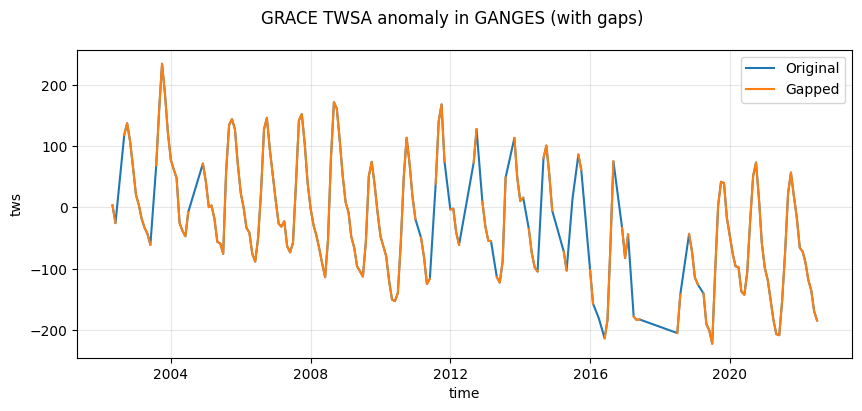

In [41]:
fig = plt.figure(figsize=(10, 4))
basin_avg_tws['tws'].plot()
basin_avg_tws_gapped['tws'].plot()
plt.grid(alpha=0.3)
plt.legend(['Original', 'Gapped'])
plt.suptitle(f'GRACE TWSA anomaly in {basin_name} (with gaps)')
plt.show()

* Same can be done quickly with the original dataset `ds`.

In [42]:
# Creating an empty gapped dataset
ds_gapped = xr.Dataset(
    data_vars=dict(
        tws=(["time","lat", "lon"], np.nan * np.ones(   [len(new_dates), len(lat), len(lon)]   )     )  ),
    coords = {
        "time":new_dates,
        "lat":lat,
        "lon":lon },
    attrs=dict(description="TWS Anomaly corresponding to long term (2004-2010) mean \n \
               data contains missing values for the months where GRACE data is unavailable"),    )

# Filling the gaps where data is available
ds_gapped['tws'] = ds['tws'].where(     ds['time'].isin(ds_gapped['time']),     )

In [43]:
ds_gapped

<xarray.Dataset> Size: 63MB
Dimensions:  (time: 243, lat: 180, lon: 360)
Coordinates:
  * time     (time) datetime64[ns] 2kB 2002-04-30 2002-05-31 ... 2022-06-30
  * lat      (lat) int64 1kB 89 88 87 86 85 84 83 ... -85 -86 -87 -88 -89 -90
  * lon      (lon) int64 3kB -180 -179 -178 -177 -176 ... 175 176 177 178 179
Data variables:
    tws      (time, lat, lon) float32 63MB -2.598 -2.549 -2.499 ... 124.4 124.6
Attributes:
    description:  TWS Anomaly corresponding to long term (2004-2010) mean \n ...

* Lets have a glance at the complete dataset now

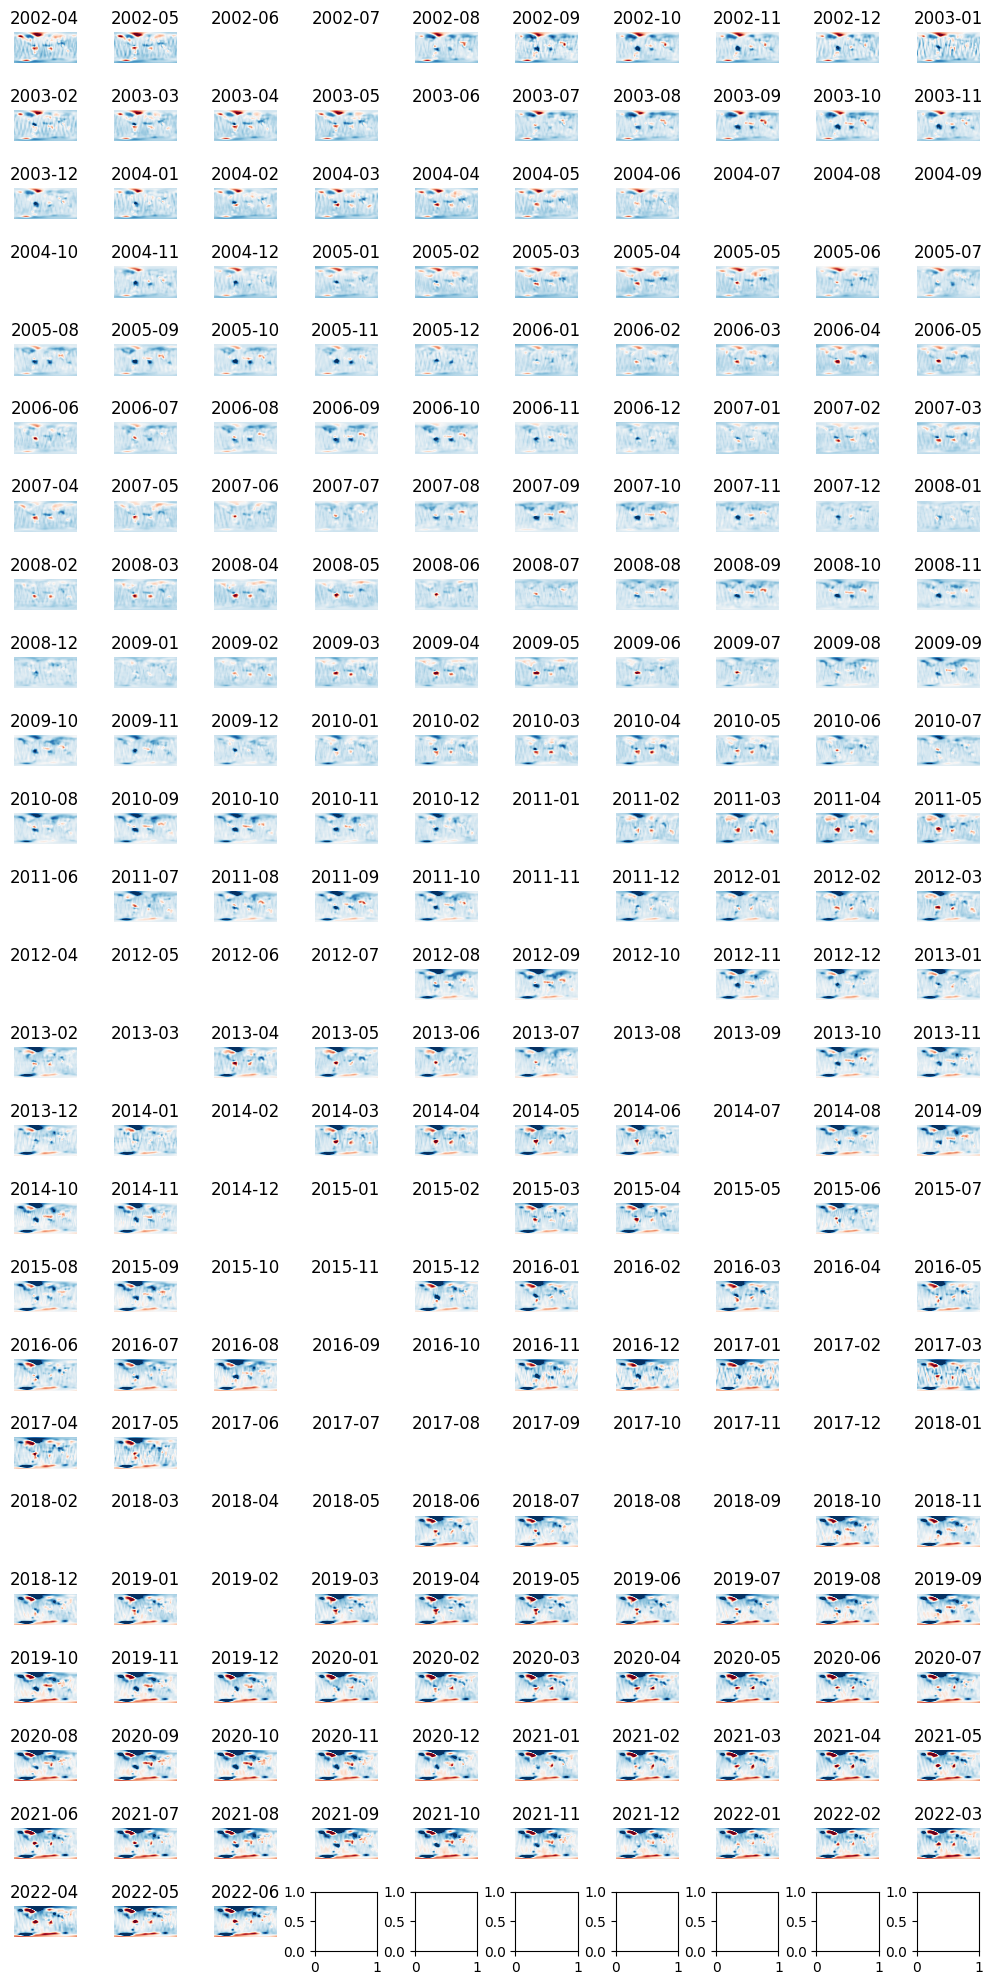

In [44]:
fig, ax = plt.subplots(nrows=(ds_gapped['time'].shape[0]//10+1), ncols=10, figsize=(10, 20))
ax_flat = ax.flatten()
for timeindex, index in enumerate(ds_gapped.time.values):
    ax_flat[timeindex].imshow(ds_gapped['tws'].sel(time=index), cmap='RdBu_r', vmin=-200, vmax=300)
    ax_flat[timeindex].set_title(ds_gapped['time'].isel(time=timeindex).dt.strftime('%Y-%m').values)
    ax_flat[timeindex].axis('off')
plt.tight_layout()
plt.show()

In [45]:
# ds.to_netcdf('../pyshbundle/validation_data/tws_py.nc')
# delta_sc.shape
# import scipy

# scipy.io.savemat('../pyshbundle/delta_sc.mat', {'delta_sc': delta_sc})

* Want to save the data?

In [46]:
# Path to save the gridded data
save_path_gridded = ''
# Path to save the basin data
save_path_basin = ''

In [47]:
# ds_gapped.to_netcdf(f'{save_path_gridded}')
# basin_avg_tws_gapped.to_pandas().to_csv(f'{save_path_basin}', sep=',',)

#### Thank you for reading!